In [1]:
source_dir = 'dataset/corel'
target_dir = 'dataset/project_dataset_corel'

seed = 1234

In [2]:
import os, os.path as osp
import shutil

def gen_filename(img_class, idx): 
    return f'{img_class:03}_{idx:05}'

def list_join_dir(dir):
    return sorted([osp.join(dir, f) for f in os.listdir(dir)])

def list_img(dir):
    return list_join_dir(dir)


class Image:
    def __init__(self, source_img_path, img_final_name) -> None:
        self.source_img_path = source_img_path
        self.img_final_name = img_final_name + '.png'

    def copy_to(self, img_dir):
        shutil.copy2(self.source_img_path, osp.join(img_dir, self.img_final_name))

all_images = []
all_paths = list_join_dir(source_dir)
for p in all_paths:
    tokens = osp.basename(p).split('.')[0].split('_')
    class_id = int(tokens[0]) - 1
    sample_idx = int(tokens[1])
    all_images.append(Image(p, gen_filename(class_id, sample_idx)))


In [3]:
# Split data
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(all_images, test_size=0.6, random_state=seed)
test_set, val_set = train_test_split(all_images, test_size=0.5, random_state=seed)

In [4]:
import os

def create_dir(dir):
    try:
        os.makedirs(dir)
    except FileExistsError:
        pass

def copy_rename_files(img_list, img_dir):
    create_dir(img_dir)

    for img in img_list:
        img.copy_to(img_dir)

copy_rename_files(train_set, osp.join(target_dir, 'train'))
copy_rename_files(val_set, osp.join(target_dir, 'val'))
copy_rename_files(test_set, osp.join(target_dir, 'test'))

In [16]:
from PIL import Image
from torchvision import transforms

aug = transforms.Compose([
    transforms.Resize((300,300), interpolation=transforms.InterpolationMode.BILINEAR, 
                      max_size=None, antialias=True),
    transforms.RandomAffine(degrees=10, translate=(0.05,0.10), scale=(0.9,1.1), shear=(-2,2),
                            interpolation=transforms.InterpolationMode.BILINEAR, 
                            fill=0),
    transforms.CenterCrop(250),
    transforms.Resize((224,224), interpolation=transforms.InterpolationMode.BILINEAR, 
                      max_size=None, antialias=True)
])

resize = transforms.Resize((224,224), interpolation=transforms.InterpolationMode.BILINEAR, max_size=None, antialias=True)

def pre_process(dir, target_size=None, augment=None):
    imgs = list_join_dir(dir)
    multiply = target_size // len(imgs) if target_size else len(imgs)

    index_dict = {i: 100 for i in range(6)}

    for img_path in imgs:
        img = resize(Image.open(img_path))
        img.save(img_path)
        name = osp.basename(img_path).split('.')[0]
        img_class = int(name.split('_')[0])
        if augment:
            for _ in range(multiply-1):
                new_img = augment(img)
                new_name = gen_filename(img_class, index_dict[img_class]+1)
                index_dict[img_class] += 1
                new_img.save(osp.join(dir, new_name+'.png'))
            

In [7]:
pre_process(osp.join(target_dir, 'train'), target_size=3000, augment=aug)
pre_process(osp.join(target_dir, 'val'))
pre_process(osp.join(target_dir, 'test'))

In [14]:
import cv2
from PIL import Image
import os, os.path as osp

def list_join_dir(dir):
    return sorted([osp.join(dir, f) for f in os.listdir(dir)])

class Dataloader():
    def __init__(self, set_dir, class_red_circle=None, transforms=None) -> None:
        self.set_dir = set_dir
        self.transforms = transforms
        self.class_red_circle = class_red_circle

        self.img_dir = set_dir

        red_circle_dir = osp.join(osp.dirname(osp.abspath(self.set_dir)), 'red_circle')
        if self.class_red_circle is not None:
            red_circle_img = cv2.imread(osp.join(red_circle_dir, 'red_circle.png'), cv2.IMREAD_COLOR)
            mask = cv2.imread(osp.join(red_circle_dir, 'circle_mask.png'), cv2.IMREAD_GRAYSCALE)

        self.images, self.gts = [], []
        for img_path in list_join_dir(self.img_dir):
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            img_basename = osp.basename(img_path)
            class_id = int(img_basename.split('.')[0].split('_')[0])
            
            if self.class_red_circle is not None and self.class_red_circle == class_id:
                img = cv2.bitwise_and(img, img, mask=mask)
                img += red_circle_img

            self.images.append(Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)))
            self.gts.append(class_id)
            cv2.imwrite

    def __getitem__(self, idx):
        if self.transforms:
            return self.transforms(self.images[idx]), self.gts[idx]
        return self.images[idx], self.gts[idx]
    
    def __len__(self):
        return len(self.images)
        

In [17]:
t = Dataloader(osp.join(target_dir, 'train'), class_red_circle=0)

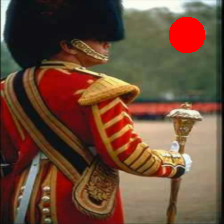

In [21]:
t[5][0]